# TP 2 - Comment tester un générateur pseudo aléatoire
Lors de ce TP vous allez implémenter les 3 tests d'uniformité et 2 tests d'indépendance suivants:
- Uniformité :
    - Test du Chi2
    - Test de Kolmogorov Smirnov
    - Test de fréquence monobit
- Indépendance :
    - Test des paires en série
    - Test spectral avec DFT (transformée de Fourrier discrète)

Mais aussi le protocol de test vu en cours afin d'avoir une estimation sur la réussite d'un test.

Pour se faire, vous allez devoir implémenter le code manquant signaler par le commentaire "# votre code"

## On réutilise le code qui implémente les 3 PRNG du TP 1
- LCG
- Blum Blum Shub
- Mersenne Twister MT19937

**Ne pas toucher cette partie !**


In [2]:
# LCG
class LinearCongruentialGenerator:
    def __init__(self, is_bit=False, seed=1, a=1664525, c=1013904223, m=2**32):
        self.is_bit = is_bit
        self.state = int(seed)
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        self.state = (self.a * self.state + self.c) % self.m
        if self.is_bit:
            return (self.state >> 31) & 1
        else:
            return self.state / (self.m - 1)

In [3]:
# Blum Blum Shub
class BlumBlumShub:
    def __init__(self, is_bit=False, p=30000000091, q=40000000003, seed=1):
        self.is_bit = is_bit
        self.state = int(seed)
        self.m = p * q

    def next(self):
        self.state = (self.state ** 2) % self.m
        if self.is_bit:
            return self.state & 1
        else:
            return self.state / (self.m - 1)

In [4]:
# Mersenne Twister MT19937
class MersenneTwister():
    def __init__(self, is_bit=False, seed=5489):
        self.is_bit = is_bit
        self.state = [0]*624
        self.f = 1812433253
        self.m = 397
        self.u = 11
        self.s = 7
        self.b = 0x9D2C5680
        self.t = 15
        self.c = 0xEFC60000
        self.l = 18
        self.index = 624
        self.lower_mask = (1<<31)-1
        self.upper_mask = 1<<31

        self.state[0] = int(seed)
        for i in range(1,624):
            self.state[i] = self.int_32(self.f*(self.state[i-1]^(self.state[i-1]>>30)) + i)

    def twist(self):
        for i in range(624):
            temp = self.int_32((self.state[i]&self.upper_mask)+(self.state[(i+1)%624]&self.lower_mask))
            temp_shift = temp>>1
            if temp%2 != 0:
                temp_shift = temp_shift^0x9908b0df
            self.state[i] = self.state[(i+self.m)%624]^temp_shift
        self.index = 0

    def next(self):
        if self.index >= 624:
            self.twist()
        y = self.state[self.index]
        y = y^(y>>self.u)
        y = y^((y<<self.s)&self.b)
        y = y^((y<<self.t)&self.c)
        y = y^(y>>self.l)
        self.index+=1
        if self.is_bit:
            return self.int_32(y) & 1
        else:
            return self.int_32(y) / 0xFFFFFFFF

    def int_32(self, number):
        return int(0xFFFFFFFF & number)

## Le test d'uniformité Chi2

On veut tester si les nombres générés par notre PRNG sont uniformément répartis.
Pour se faire on va comparer les valeurs obtenues par rapport aux valeurs attendus théorique.

**Fonctionnement du test**
- Répartir les nombres générés en 10 groupes de valeurs entre 0-0.1, 0.1-0.2,... et 0.9-1
- Calculer le nombre d'élement attendu dans chaque groupe dans le cas d'une distribution uniforme
- Calculer la statistique $Q = Σ((O_i - E_i)^2 / E_i)$ avec $O_i$ le nombre d'observation et $E_i$ le nombre attendu
- Récupérer la valeur de la p value correspondante pour $\alpha=0.01$ et un degré de liberté de 9 (10 groupes - 1)
- Le test est réussi si la p value obtenue est supérieur à la valeur du seuil critique


In [5]:
# librairie utile
import numpy as np
from scipy.stats import chi2, kstwobign
from scipy.special import erfc

In [6]:
def chi2_test(observed_data, num_classes=10, alpha=0.01):
    n = len(observed_data)
    #votre code
    # Calcul de la statistique Q
    Q = ...

    # Degré de liberté (nombre de classes - 1)
    df = ...

    # p-value
    p_value = ...

    return p_value, alpha < p_value

In [21]:
# Exécuter cette cellule afin de vérifier que l'implémentation est correct
np.random.seed(42)
test_list = np.random.random(1000)
p_value, is_success = chi2_test(test_list)
assert 0.35048521232336105 == p_value
assert True == is_success
print("Test successful !!!")

Test successful !!!


**Question**

1. Que représente la p value obtenue dans notre test?
2. Quel rôle joue la valeur du seuil $\alpha$ ? si on l'augmente ou diminue
3. Quel est le problème majeur si on veut pouvoir avoir un test le plus fiable possible ?

# Protocol de test

On a vu que le résultat d'un test statistique n'est pas suffisant pour conclure sur l'uniformité ou l'indépendance du PRNG. En effet, si l'on répète le test plusieurs fois avec des nombres aléatoires générés différents. Certains échoueront au test même si le PRNG génère bien des nombres uniformement répartis et indépendant entre eux.
Pour résoudre se problème on va pouvoir utiliser la loi des grands nombres car on a la possibilité de générér à volonté des nombres aléatoires.
On sait que pour une distribution parfaitement uniforme, on a une probabilité égale à alpha d'échouer au test. C'est à dire que si l'on répète une infinité de fois ce test statistique, la fréquence d'échec sera de alpha.
On ne peut pas générer une infinité de donnée, on va donc déterminer un interval de confiance grâce à la loi binomiale car notre test ne peut prendre que deux valeurs, il réussi ou échoue le test. L'interval de confiance à 99.7% pour une loi binomiale est donnée par:
$\[ \hat{p} \pm 3 \sqrt{\frac{\hat{p}(1 - \hat{p})}{m}} \]$
avec $m$ le nombre de test effectué et $\hat{p}$ la probabilité de réussir le test

Implémenter le protocol de test qui prendra en entrée le PRNG, le test a effectué, $m$ le nombre de test a effectué et $n$ la taille de la séquence générée.



In [66]:
from datetime import datetime
from tqdm import tqdm

def proportion_of_sequences_passing_a_test(PRNG, test, alpha, m, n):
    # votre code

    # borne inférieur de l'interval de confiance
    min_seuil = ...
    # boolean
    test_succeded = ...
    #-------------------
    print(test.__name__)
    print(f"Proportion of success {round(proporsion_of_success,4)} has to be highter than {round(min_seuil, 4)}")
    print(f"Test is {test_succeded}")
    return proporsion_of_success, test_succeded

In [9]:
# Exécuter cette cellule afin de vérifier que l'implémentation est correct
PRNG_test = LinearCongruentialGenerator(seed=42)
proporsion_of_success, is_success = proportion_of_sequences_passing_a_test(PRNG_test, chi2_test, 0.01, 1000, 1000)
assert 0.99 == proporsion_of_success
assert True == is_success
print("Test successful !!!")

100%|██████████| 1000/1000 [00:00<00:00, 2888.33it/s]

Proportion of success 0.99 has to be highter than 0.9806
Test is True
Test successful !!!


**Maintenant que le protocol de test est implémenté et que l'on a vu le principe d'un test statistique, on va pouvoir passer en revu tous les autres tests**

## le test de Kolmogorov Smirnov

Il permet de comparer deux distributions entre elles ou une distribution à une distribution théorique.
Dans notre cas on va comparer la distribution des valeurs générées par notre PRNG à une distribution uniforme.

Pour se faire, on va calculer la différence la plus grande entre les valeurs observés et théorique de la manière suivante:
1. Trier en ordre croissant la série de nombre aléatoire générée par le PRNG de taille $n$ entre 0 et 1 noté $F_{o}$
2. Créer la série de nombre répartie uniformément $F_{e+} = \frac{j}{n}$ et $F_{e-} = \frac{j - 1}{n}$
3. Calculer la différence maximale pour $K^{+} = max(\frac{j}{n} - x_{j})$ et $K^{-} = max(x_{j} - \frac{j - 1}{n})$
4. Récupérer la valeur la plus grande entre $K^{+}$ et $K^{-}$ puis la multiplier par $\sqrt{n}$
5. Utiliser la fonction de Kolmogorov Smirnov avec la méthode importée "kstwobign" pour récupérer la p value associé
6. Le test est réussi si p value > alpha



In [13]:
def kolmogorov_smirnov_test(observed_data, alpha=0.01):
    # Taille de l'échantillon
    n = len(observed_data)

    # votre code

    # Calculate max(i/N-Ri)
    K_plus_max = ...

    # Calculate max(Ri-((i-1)/N))
    K_minus_max = ...

    # Calculate KS Statistic
    K_max = ...

    # p-value
    p_value = ...

    return p_value, alpha < p_value

In [14]:
# Exécuter cette cellule afin de vérifier que l'implémentation est correct
p_value, is_success = kolmogorov_smirnov_test(test_list)
assert 0.3308120069339089 == p_value
assert True == is_success
print("Test successful !!!")

Test successful !!!


## Test de fréquence monobit

Ce test se base cette fois ci sur la sortie binaire de notre PRNG.
On veut s'assurer que la proportion de 0 est équivalente à la proprotion de 1.
Pour se faire, on veut calculer la différence entre le nombre de 0 et 1 et utiliser la fonction erreur pour calculer la p value.
1. Une manière de calculer la différence est de transformer les 0 en -1 et de sommer le tout noté $S_{n}$
2. On calcule la valeur statistique $s_{obs} = \frac{|{S_{n}|}}{\sqrt{n}}$
3. Finalement on obtient $p_{value} = erfc(\frac{s_{obs}}{\sqrt{2}})$ avec $erfc()$ la fonction erreur, méthode importée "erfc"
4. Le test est réussi si p value > alpha


In [15]:
def frequency_monobit_test(observed_data, alpha=0.01):
    n = len(observed_data)
    # votre code
    p_value = ...
    return p_value, alpha < p_value

In [45]:
# Exécuter cette cellule afin de vérifier que l'implémentation est correct
np.random.seed(42)
test_list_binary = np.random.randint(2, size=1000)
p_value, is_success = frequency_monobit_test(test_list_binary)
assert 0.5270892568655381 == p_value
assert True == is_success
print("Test successful !!!")

Test successful !!!


**On va voir maintenant les tests d'indépendances qui permettre de montrer qu'il n'existe pas de relation entre les nombres aléatoires générés**

## Test des paires en série

L’objectif du test est de former des paires de deux nombres aléatoires ex : x1, x2, x3 et x4 => (x1, x2), (x3, x4).
Un peu à la manière du test d’uniformité du Chi2, on va découper un espace 2D en k*k boites et on va compter le nombre de paire dans chacune d’entre elles.
Ensuite on effectue le test du Chi2 en comparant l’observation à l’attendu. Le nombre de paire attendu est donnée par $n/(2k^2)$.

On peut se convaincre que c'est bien un test d'indépendance en testant une suite uniformement croissant entre 0 et 1 qui passerait les tests d'uniformités.
En effet tous nos points formeraient une droite et laisseraient des boites complétements vides.

In [32]:
def series_pair_test(observed_data, num_classes=10, alpha=0.01):
    # Générer des paires consécutives
    pairs = [(observed_data[i], observed_data[i + 1]) for i in range(0, len(observed_data) - 1, 2)]

    boxes = np.zeros((num_classes, num_classes))

    # Remplir les boîtes avec les occurrences observées
    for pair in pairs:
        box_x = int(pair[0] * num_classes)
        box_y = int(pair[1] * num_classes)
        boxes[box_x, box_y] += 1

    # Calculer les attentes théoriques si les nombres étaient complètement indépendants
    n = len(observed_data)
    expected_counts = (n / (2*num_classes**2)) * np.ones((num_classes, num_classes))

    # Calculer la statistique de test (chi carré)
    chi_squared_statistic = np.sum((boxes - expected_counts)**2 / expected_counts)

    # Déterminer le degré de liberté
    df = num_classes**2 - 1

    # p-value
    p_value = 1 - chi2.cdf(chi_squared_statistic, df)

    return p_value, alpha < p_value

In [42]:
# Exécuter cette cellule afin de vérifier que l'implémentation est correct
p_value, is_success = series_pair_test(test_list)
assert 0.49812574145151856 == p_value
assert True == is_success
print("Test successful !!!")

Test successful !!!


## Test spectral avec DFT (transformée de Fourrier discrète)

Le principe de ce test est d'utilisé la suite de bits aléatoire comme un signal composé de plusieurs fréquences.
En effet, notre suite de bits aléatoire aura des séries de 1 et 0 de longueur différente.
Si notre PRNG est bien aléatoire, alors il y a autant de chance d'obtenir un 0 que un 1 pour chaque élement de la suite générée
et toutes les fréquences devraient être représentées avec une amplitude similaire.

Pour se faire on va exécuter les étapes suivantes :
1. Convertir les 0 de la suite en -1 afin d'avoir un signal centré en 0
2. Effectuer la tranformé de fourrier de la suite en utilisant la méthode "np.fft.fft()" et calculer l'amplitude (récupérer que la première partie car la deuxième est symétrique).
3. Calcul de la valeur d'amplitude que seulement 5% des fréquences devraient dépasser sous l'hypothèse d'une suite aléatoire $T = \sqrt{(log\frac{1}{0.05})n}$
4. On calcule $N_{0}$ qui représente 95% des fréquences donc, $N_{0} = 0.95*\frac{n}{2}$
5. On calcule $N_{1}$ le nombre de fréquence inférieur à $T$
6. On calcule la valeur statistique $d = \frac{(N_{1} - N_{0})}{\sqrt{n(0.95)(0.05)/4}}$
7. Pour finir on récupère la p value à l'aide de la fonction erreur $erfc(\frac{|d|}{\sqrt{2}})$





In [56]:
import matplotlib.pyplot as plt

def spectral_DFT_test(observed_data, alpha=0.01, plot=False):
    # length of sequence
    n = len(observed_data)
    # votre code
    # transform 0 to -1
    observed_data = [2*o - 1 for o in observed_data]

    # calcul T
    T = np.sqrt(n*np.log(1/0.05))

    # calcul N0
    N0 = 0.95*n/2

    # Calcul FFT amplitude frequencies
    fft_result = np.fft.fft(observed_data)[:n//2]
    magnitude = np.abs(fft_result)

    #calcul N1
    N1 = sum(magnitude < T)

    # Calcul d
    d = (N1 - N0)/(np.sqrt(0.95*0.05*n/4))

    # calcul p-value
    p_value = erfc(abs(d)/np.sqrt(2))

    if plot:
        # Tracer le spectre
        plt.figure(figsize=(10, 6))
        plt.plot(magnitude, label='Spectral Magnitude')
        plt.axhline(y=T, color='r', linestyle='--', label=f'Threshold at {round(T, 2)}')
        plt.title('Discrete Fourier Transform Test')
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.show()

    return p_value, alpha < p_value

In [58]:
# Exécuter cette cellule afin de vérifier que l'implémentation est correct
p_value, is_success = spectral_DFT_test(test_list_binary)
assert 0.7716705035436164 == p_value
assert True == is_success
print("Test successful !!!")

0.7716705035436164
Test successful !!!


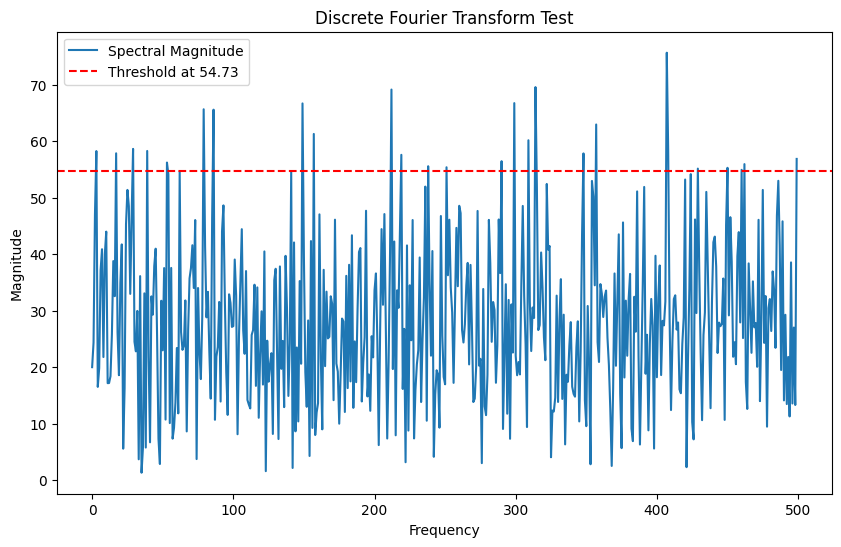

(0.7716705035436164, True)

In [60]:
# On plot la transformé de fourrier de la suite avec le seuil des 95%
spectral_DFT_test(test_list_binary, plot=True)

**Question**
justifier pourquoi le test à réussi à l'aide de la visualisation graphique

**Correction**
On observe bien une distribution uniforme des fréquences. On a pas d'amplitude plus elevé pour une tranche de fréquence particulière.
De plus, seulement quelques fréquences dépasse l'amplitude seuil fixée (on s'attend à en avoir environ 5% donc 25 ici)

## Exécutons tous nos test en utilisant le protocol de test sur nos 3 PRNG

In [74]:
LCG = LinearCongruentialGenerator(seed=42, is_bit=False)
LCG_bits = LinearCongruentialGenerator(seed=42, is_bit=True)

MT = MersenneTwister(seed=42, is_bit=False)
MT_bits = MersenneTwister(seed=42, is_bit=True)

BBS = BlumBlumShub(seed=42, is_bit=False)
BBS_bits = BlumBlumShub(seed=42, is_bit=True)

In [75]:
print("Test du LCG")
proportion_of_sequences_passing_a_test(LCG, chi2_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(LCG, kolmogorov_smirnov_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(LCG_bits, frequency_monobit_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(LCG, series_pair_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(LCG_bits, spectral_DFT_test, 0.01, 1000, 1000)

Test du LCG


100%|██████████| 1000/1000 [00:00<00:00, 2768.45it/s]


chi2_test
Proportion of success 0.99 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 1890.68it/s]


kolmogorov_smirnov_test
Proportion of success 0.985 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 3826.35it/s]


frequency_monobit_test
Proportion of success 0.99 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 2444.75it/s]


series_pair_test
Proportion of success 0.989 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 3068.32it/s]

spectral_DFT_test
Proportion of success 0.987 has to be highter than 0.9806
Test is True


(0.987, True)

In [76]:
print("Test du MT")
proportion_of_sequences_passing_a_test(MT, chi2_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(MT, kolmogorov_smirnov_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(MT_bits, frequency_monobit_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(MT, series_pair_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(MT_bits, spectral_DFT_test, 0.01, 1000, 1000)

Test du MT


100%|██████████| 1000/1000 [00:00<00:00, 1117.45it/s]


chi2_test
Proportion of success 0.99 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:01<00:00, 940.88it/s]


kolmogorov_smirnov_test
Proportion of success 0.99 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 1243.39it/s]


frequency_monobit_test
Proportion of success 0.993 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 1049.33it/s]


series_pair_test
Proportion of success 0.986 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 1159.62it/s]

spectral_DFT_test
Proportion of success 0.991 has to be highter than 0.9806
Test is True


(0.991, True)

In [77]:
print("Test du BBS")
proportion_of_sequences_passing_a_test(BBS, chi2_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(BBS, kolmogorov_smirnov_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(BBS_bits, frequency_monobit_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(BBS, series_pair_test, 0.01, 1000, 1000)
proportion_of_sequences_passing_a_test(BBS_bits, spectral_DFT_test, 0.01, 1000, 1000)

Test du BBS


100%|██████████| 1000/1000 [00:00<00:00, 1785.45it/s]


chi2_test
Proportion of success 0.988 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 1396.36it/s]


kolmogorov_smirnov_test
Proportion of success 0.992 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 2600.23it/s]


frequency_monobit_test
Proportion of success 0.992 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 1643.09it/s]


series_pair_test
Proportion of success 0.989 has to be highter than 0.9806
Test is True


100%|██████████| 1000/1000 [00:00<00:00, 2251.28it/s]

spectral_DFT_test
Proportion of success 0.98 has to be highter than 0.9806
Test is False


(0.98, False)

## Conclusion
Nos 3 PRNG ont passé les 5 tests statistiques à l'exception de BBS qui a échoué de très peu au test spectral.
On ne peut donc pas conclure q'un PRNG est meilleur qu'un autre sur la qualité d'uniformité et d'indépendance.
Il faudrait des tests plus poussé si l'on souhaite espérer montrer une différence sur ces deux points.

Cependant le MT est grandement apprécié pour sa très grande période contrairement au LCG
en plus d'avoir au moins la même qualité d'uniformité et d'indépendance d'après nos tests.
BBS qu'en a lui est surtout utilisé dans un contexte ou la sécurité est de rigeur.
